# Market Sentiment vs Trader Behavior Analysis

## Objective
The objective of this analysis is to study how trader behavior
(profitability, leverage, volume) aligns or diverges from overall
Bitcoin market sentiment classified as Fear or Greed.


# 1. IMPORT LIBRARIES

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set()

# 2. LOAD DATASETS

In [20]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

print("Trades shape:", trades.shape)
print("Sentiment shape:", sentiment.shape)

Trades shape: (211224, 16)
Sentiment shape: (2644, 4)


# 3. CLEAN COLUMN NAMES

In [21]:
trades.columns = trades.columns.str.strip().str.lower()
sentiment.columns = sentiment.columns.str.strip().str.lower()

print(trades.columns)
print(sentiment.columns)

Index(['account', 'coin', 'execution price', 'size tokens', 'size usd', 'side',
       'timestamp ist', 'start position', 'direction', 'closed pnl',
       'transaction hash', 'order id', 'crossed', 'fee', 'trade id',
       'timestamp'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


# 4. DATE & TIME PREPROCESSING

In [22]:
# Convert trade timestamp (Indian format: DD-MM-YYYY HH:MM)
trades['timestamp ist'] = pd.to_datetime(
    trades['timestamp ist'],
    dayfirst=True,
    errors='coerce'
)

# Create date column for merge
trades['date'] = trades['timestamp ist'].dt.date

# Convert sentiment date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# 5. MERGE DATASETS

In [23]:
merged = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)

print("Merged shape:", merged.shape)
merged.head()

Merged shape: (211218, 18)


,account,coin,execution price,size tokens,size usd,side,timestamp ist,start position,direction,closed pnl,transaction hash,order id,crossed,fee,trade id,timestamp,date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,Extreme Greed


# 6. SANITY CHECK

In [24]:
print(merged['classification'].value_counts())

classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64


# 7. FEATURE ENGINEERING

In [25]:
merged['trade_volume'] = merged['execution price'] * merged['size usd']

# Profitability flag
merged['is_profitable'] = merged['closed pnl'] > 0

# 8. ANALYSIS 1: PROFITABILITY vs SENTIMENT

In [27]:
import os

os.makedirs("outputs", exist_ok=True)

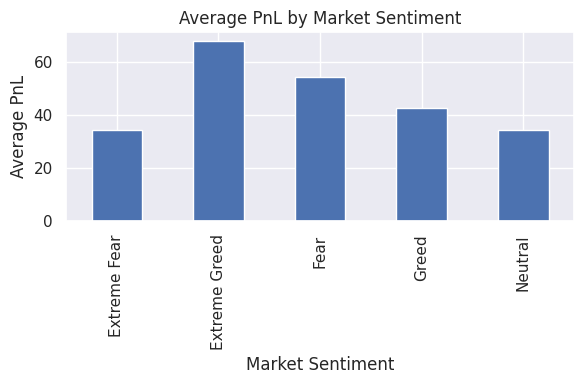

In [28]:
plt.figure(figsize=(6,4))
merged.groupby('classification')['closed pnl'].mean().plot(kind='bar')
plt.title("Average PnL by Market Sentiment")
plt.ylabel("Average PnL")
plt.xlabel("Market Sentiment")
plt.tight_layout()
plt.savefig("outputs/pnl_vs_sentiment.png")
plt.show()

# 9. ANALYSIS 2: LEVERAGE BEHAVIOR

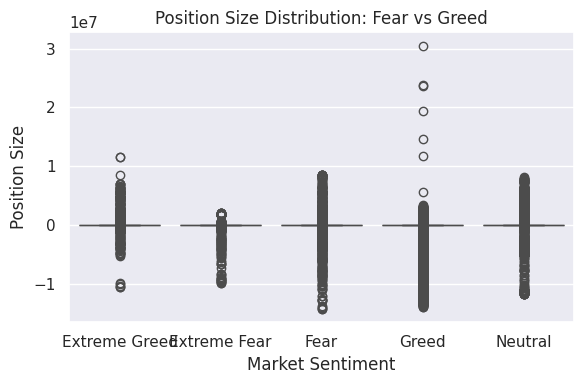

In [29]:
plt.figure(figsize=(6,4))
sns.boxplot(
    x='classification',
    y='start position',
    data=merged
)
plt.title("Position Size Distribution: Fear vs Greed")
plt.xlabel("Market Sentiment")
plt.ylabel("Position Size")
plt.tight_layout()
plt.savefig("outputs/position_vs_sentiment.png")
plt.show()

# 10. ANALYSIS 3: TRADE VOLUME

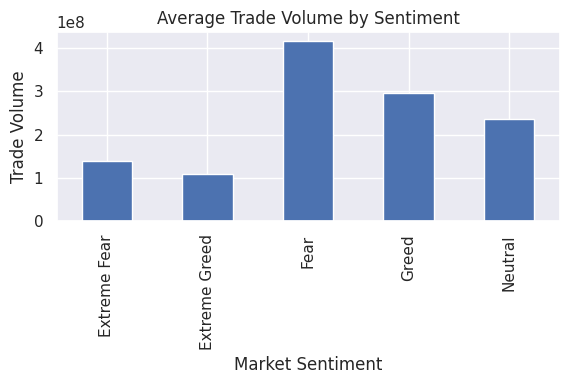

In [30]:
plt.figure(figsize=(6,4))
merged.groupby('classification')['trade_volume'].mean().plot(kind='bar')
plt.title("Average Trade Volume by Sentiment")
plt.ylabel("Trade Volume")
plt.xlabel("Market Sentiment")
plt.tight_layout()
plt.savefig("outputs/volume_vs_sentiment.png")
plt.show()

# 11. WIN RATE ANALYSIS

In [31]:
win_rate = merged.groupby('classification')['is_profitable'].mean()
print("Win Rate by Sentiment:")
print(win_rate)

Win Rate by Sentiment:
classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: is_profitable, dtype: float64
